# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# All Imports
import numpy as np
import cv2                
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets  
from PIL import Image
from PIL import ImageFile
from glob import glob
from tqdm import tqdm
import os

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


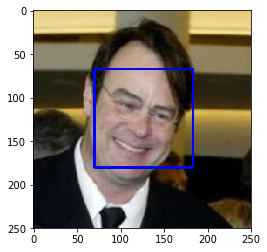

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

98% of the first images in human_files have faces detected inside them.

17% of the first images in dog_files have faces detected inside them.

In [22]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

faces_in_humans = 0
faces_in_dogs = 0

for path in tqdm(human_files_short):
    if face_detector(path):
        faces_in_humans += 1
        
for path in tqdm(dog_files_short):
    if face_detector(path):
        faces_in_dogs += 1
        
print("Percentage of human images with a detected face: {}%".format(faces_in_humans))
print("Percentage of dog images with a detected face: {}%".format(faces_in_dogs))

100%|██████████| 100/100 [00:30<00:00,  3.29it/s]

Percentage of human images with a detected face: 98%
Percentage of dog images with a detected face: 17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 103498592.02it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [6]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    
    with torch.no_grad():
        # Don't want to affect any of the weights for this portion.
        VGG16.eval()

        # resize to 224 x 224, smallest size the network will accept. Saves time, maybe sacrifices acccuracy?
        transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225))])

        # Discard the transparent channel, if present.
        image = transform(Image.open(img_path))[:3,:,:]

        if use_cuda:
            image = image.cuda()

        # Add the batch dimension.
        image = image.unsqueeze(0)

        # Get the tensor output
        output = VGG16(image)
        # Returns maximum value and index for each row in the tensor. We only care about indices for now.
        _, pred = torch.max(output, 1)  

        return pred.item() # predicted class index

print(dog_files[2])
print(VGG16_predict(dog_files[2]))

/data/dog_images/train/103.Mastiff/Mastiff_06871.jpg
243


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    pred = VGG16_predict(img_path)
    
    if 151 <= pred <= 268:
        return True
    else:
        return False # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

0% of the first human images contained a detected dog.

100% of the first dog images contained a detected dog.


In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dogs_in_humans = 0
dogs_in_dogs = 0

for path in tqdm(human_files_short):
    if dog_detector(path):
        dogs_in_humans += 1
        
for path in tqdm(dog_files_short):
    if dog_detector(path):
        dogs_in_dogs += 1
        
print("Percentage of human images with a detected dog: {}%".format(dogs_in_humans))
print("Percentage of dog images with a detected dog: {}%".format(dogs_in_dogs))

100%|██████████| 100/100 [00:04<00:00, 25.21it/s]

Percentage of human images with a detected dog: 0%
Percentage of dog images with a detected dog: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

resnet18 = models.resnet18(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    resnet18 = resnet18.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 68907094.50it/s]


In [12]:
def resnet18_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Don't want to affect any of the weights for this portion.
    resnet18.eval()
    
    # resize to 224 x 224, smallest size the network will accept. Saves time, maybe sacrifices accuracy?
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])
    
    # Discard the transparent channel, if present.
    image = transform(Image.open(img_path))[:3,:,:]
    
    if use_cuda:
        image = image.cuda()
    
    # Add the batch dimension.
    image = image.unsqueeze(0)
    
    # Get the tensor output
    output = resnet18(image)
    # Returns maximum value and index for each row in the tensor. We only care about indices for now.
    _, pred = torch.max(output, 1)  
    
    return pred.item() # predicted class index

print(dog_files[2])
print(resnet18_predict(dog_files[2]))

/data/dog_images/train/103.Mastiff/Mastiff_06871.jpg
243


In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector_resnet18(img_path):
    ## TODO: Complete the function.
    
    pred = resnet18_predict(img_path)
    
    if pred > 150 and pred < 269:
        return True
    else:
        return False # true/false

In [14]:
dogs_in_humans = 0
dogs_in_dogs = 0

for path in tqdm(human_files_short):
    if dog_detector_resnet18(path):
        dogs_in_humans += 1
        
for path in tqdm(dog_files_short):
    if dog_detector_resnet18(path):
        dogs_in_dogs += 1
        
print("Percentage of human images with a detected dog: {}%".format(dogs_in_humans))
print("Percentage of dog images with a detected dog: {}%".format(dogs_in_dogs))

100%|██████████| 100/100 [00:02<00:00, 42.11it/s]

Percentage of human images with a detected dog: 1%
Percentage of dog images with a detected dog: 100%


__Observation__ - ResNet18:

1% of the first human images contained a detected dog.

100% of the first dog images contained a detected dog.

While ResNet18 also does very well, 1 of the first 100 human images was classified as containing a dog. This performs slightly worse at this task than VGG16. As a result, VGG16 will be the model used for the remainder of this project.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [8]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.2),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

num_workers = 0
batch_size = 100

# load the training and test datasets
data_scratch = {'train': datasets.ImageFolder(root='/data/dog_images/train', transform=train_transform),
                'valid': datasets.ImageFolder(root='/data/dog_images/valid', transform=test_transform),
                'test': datasets.ImageFolder(root='/data/dog_images/test', transform=test_transform)}

loaders_scratch = {'train': torch.utils.data.DataLoader(data_scratch['train'], 
                                                        batch_size=batch_size, 
                                                        num_workers=num_workers, 
                                                        shuffle=True),
                   'valid': torch.utils.data.DataLoader(data_scratch['valid'], 
                                                        batch_size=batch_size, 
                                                        num_workers=num_workers),
                   'test': torch.utils.data.DataLoader(data_scratch['test'], 
                                                       batch_size=batch_size, 
                                                       num_workers=num_workers)}

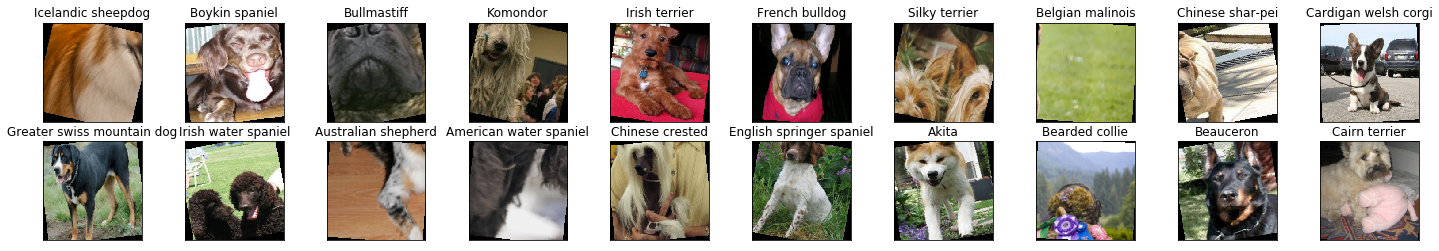

In [9]:
# Taken from Transfer Learning lesson
# Visualize some sample data

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
class_names = [item[4:].replace("_", " ") for item in data_scratch['train'].classes]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(class_names[labels[idx]])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

The code stretches or shrinks the images to 256 * 256, before randomly cropping and resizing to 224\*224 images through the Random Resized Crop. I chose this size as it is the minimum size required to use the pretrained models provided with PyTorch. This could reduce accuracy of the system but will allow for faster processing.

I augmented the training dataset using random horizontal flips, with a 20% chance of occuring and random rotations of up to 15 degrees. This should provide a little bit of variation to train the model better. No augmentation was used for the validation or test set, as the original image is what needs to be recognised.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.result_shape = 7 * 7 * 128
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # Linear layers
        self.fc1 = nn.Linear(self.result_shape, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 133)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # MaxPooling
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        ## Define forward behavior
        
        #Dimension changes with Maxpooling (2, 2)
        # 224 * 224 --> 112 * 112 --> 56 * 56
        x = self.pool(self.conv1(x))
        # 56 * 56 --> 28 * 28 --> 14 * 14
        x = self.pool(self.conv2(x))
        # 14 * 14 --> 7 * 7
        x = self.pool(self.conv3(x))
        
        # Flattening image
        x = x.view(-1, (self.result_shape))
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I opted for 3 convolutional layers, each followed by  a maxpooling layer of stride 2, in order to half the size of the image each time. The first two convolutional layers also have a stride of 2 to further downsample the image, while the last has a stride of 1, keeping the image size the same. The depth increases to 32 filters in the first layer, and doubles with each consecutive convolutional layer.

These are followed by three linear layers, each with a 25% chance of dropout beforehand. The first two linear layers are each succeeded by a ReLU function, while the last layer remains without an activation function, as Softmax will be calculated as part of the Cross Entropy Loss function that will be used next. Each of these Linear layers are fully connected, with the first two containing 512 nodes, and the last layer containing 133 nodes for output.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [11]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, pt=False):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    start_epoch = 1
    losses = {'train': [], 'valid': []}
    
    if pt:

        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        valid_loss_min = checkpoint['valid_loss']
    
    for epoch in tqdm(range(start_epoch, n_epochs+1)):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss += loss.item() * data.size(0)
        
        # Average the losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        losses['train'].append(train_loss)
        losses['valid'].append(valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, valid_loss))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'valid_loss': valid_loss
                }, save_path)
            
            valid_loss_min = valid_loss
    
    # Plot train and validation loss
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['valid'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()
    
    # return trained model
    return model


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 4.800414 	Validation Loss: 4.570252
Validation loss decreased (inf --> 4.570252).  Saving model ...


  8%|▊         | 2/25 [03:52<45:46, 119.40s/it]

Epoch: 2 	Training Loss: 4.610282 	Validation Loss: 4.371559
Validation loss decreased (4.570252 --> 4.371559).  Saving model ...


 12%|█▏        | 3/25 [05:40<42:32, 116.02s/it]

Epoch: 3 	Training Loss: 4.498078 	Validation Loss: 4.190210
Validation loss decreased (4.371559 --> 4.190210).  Saving model ...


 16%|█▌        | 4/25 [07:27<39:41, 113.41s/it]

Epoch: 4 	Training Loss: 4.406455 	Validation Loss: 4.169190
Validation loss decreased (4.190210 --> 4.169190).  Saving model ...


 20%|██        | 5/25 [09:14<37:11, 111.57s/it]

Epoch: 5 	Training Loss: 4.362167 	Validation Loss: 4.112444
Validation loss decreased (4.169190 --> 4.112444).  Saving model ...


 24%|██▍       | 6/25 [11:01<34:54, 110.26s/it]

Epoch: 6 	Training Loss: 4.275813 	Validation Loss: 4.081049
Validation loss decreased (4.112444 --> 4.081049).  Saving model ...


 28%|██▊       | 7/25 [12:49<32:48, 109.38s/it]

Epoch: 7 	Training Loss: 4.218832 	Validation Loss: 3.975030
Validation loss decreased (4.081049 --> 3.975030).  Saving model ...


 32%|███▏      | 8/25 [14:37<30:51, 108.91s/it]

Epoch: 8 	Training Loss: 4.182300 	Validation Loss: 3.949024
Validation loss decreased (3.975030 --> 3.949024).  Saving model ...


 36%|███▌      | 9/25 [16:24<28:53, 108.36s/it]

Epoch: 9 	Training Loss: 4.121693 	Validation Loss: 3.882365
Validation loss decreased (3.949024 --> 3.882365).  Saving model ...


 40%|████      | 10/25 [18:11<27:01, 108.08s/it]

Epoch: 10 	Training Loss: 4.074595 	Validation Loss: 3.906230


 44%|████▍     | 11/25 [19:59<25:11, 107.99s/it]

Epoch: 11 	Training Loss: 4.045520 	Validation Loss: 3.837805
Validation loss decreased (3.882365 --> 3.837805).  Saving model ...


 48%|████▊     | 12/25 [21:47<23:22, 107.91s/it]

Epoch: 12 	Training Loss: 4.006924 	Validation Loss: 3.786912
Validation loss decreased (3.837805 --> 3.786912).  Saving model ...


 52%|█████▏    | 13/25 [23:34<21:32, 107.72s/it]

Epoch: 13 	Training Loss: 3.974659 	Validation Loss: 3.865853


 56%|█████▌    | 14/25 [25:21<19:42, 107.53s/it]

Epoch: 14 	Training Loss: 3.938884 	Validation Loss: 3.780818
Validation loss decreased (3.786912 --> 3.780818).  Saving model ...


 60%|██████    | 15/25 [27:06<17:47, 106.71s/it]

Epoch: 15 	Training Loss: 3.888518 	Validation Loss: 3.688055
Validation loss decreased (3.780818 --> 3.688055).  Saving model ...


 64%|██████▍   | 16/25 [28:51<15:56, 106.23s/it]

Epoch: 16 	Training Loss: 3.874750 	Validation Loss: 3.687510
Validation loss decreased (3.688055 --> 3.687510).  Saving model ...


 68%|██████▊   | 17/25 [30:38<14:11, 106.41s/it]

Epoch: 17 	Training Loss: 3.829071 	Validation Loss: 3.639206
Validation loss decreased (3.687510 --> 3.639206).  Saving model ...


 72%|███████▏  | 18/25 [32:25<12:26, 106.63s/it]

Epoch: 18 	Training Loss: 3.826374 	Validation Loss: 3.625842
Validation loss decreased (3.639206 --> 3.625842).  Saving model ...


 76%|███████▌  | 19/25 [34:11<10:38, 106.43s/it]

Epoch: 19 	Training Loss: 3.776191 	Validation Loss: 3.646758


 80%|████████  | 20/25 [35:55<08:48, 105.73s/it]

Epoch: 20 	Training Loss: 3.781019 	Validation Loss: 3.696760


 84%|████████▍ | 21/25 [37:40<07:02, 105.51s/it]

Epoch: 21 	Training Loss: 3.715683 	Validation Loss: 3.685500


 88%|████████▊ | 22/25 [39:27<05:17, 105.96s/it]

Epoch: 22 	Training Loss: 3.692331 	Validation Loss: 3.551215
Validation loss decreased (3.625842 --> 3.551215).  Saving model ...


 92%|█████████▏| 23/25 [41:14<03:32, 106.35s/it]

Epoch: 23 	Training Loss: 3.656906 	Validation Loss: 3.546459
Validation loss decreased (3.551215 --> 3.546459).  Saving model ...


 96%|█████████▌| 24/25 [43:02<01:46, 106.66s/it]

Epoch: 24 	Training Loss: 3.666271 	Validation Loss: 3.627167


100%|██████████| 25/25 [44:49<00:00, 106.91s/it]

Epoch: 25 	Training Loss: 3.650796 	Validation Loss: 3.551984


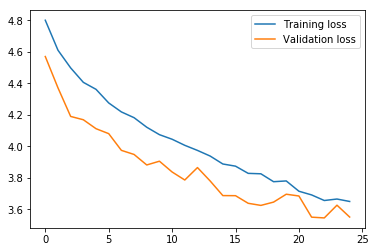

In [13]:
# train the model
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
# test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

In [15]:
# call test function
checkpoint = torch.load('model_scratch.pt')
model_scratch.load_state_dict(checkpoint['model_state_dict'])

test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.533730


Test Accuracy: 16% (137/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
## TODO: Specify data loaders

import os
from torchvision import datasets

use_cuda = torch.cuda.is_available()

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.2),
                                      transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

num_workers = 0
batch_size = 100

# load the training and test datasets

data_transfer = data_scratch.copy()

loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)
    
    # Freeze parameters
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
model_transfer.classifier[6] = nn.Linear(4096, len(data_transfer["train"].classes))
    
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

The only changes in architecture were in the classifier. Here I only replaced the final classification layer, simply changing the number of output nodes to 133. VGGNet does a brilliant job of classifying 1000 different image types, and I believe these effects will still be noticable with fewer classes. Replacing the final layer effectively reset the weights and biases for training as well as condensing the number of outputs as necessary.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [15]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

 50%|█████     | 1/2 [03:34<03:34, 214.95s/it]

Epoch: 9 	Training Loss: 2.377072 	Validation Loss: 0.956738
Epoch: 10 	Training Loss: 2.359469 	Validation Loss: 0.876178
Validation loss decreased (0.953097 --> 0.876178).  Saving model ...


100%|██████████| 2/2 [06:55<00:00, 210.67s/it]


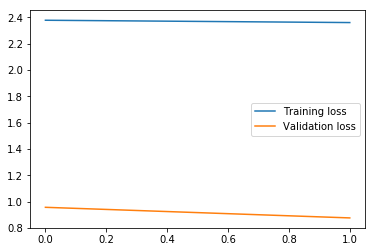

In [16]:
# train the model
n_epochs = 10

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt', pt=True)

# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt')['model_state_dict'])

**NOTE:** Sadly, due to internet issues I was unable to train the network all at once, and forgot to include the dict of losses when saving the model, so only the last two epochs are shown in this graph. However, there was no evidence of overfitting when reading the loss values at each epoch; the training and validation losses both decreased fairly continuously.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [17]:
# Load in model if necessary

checkpoint = torch.load('model_transfer.pt')
model_transfer.load_state_dict(checkpoint['model_state_dict'])

model_transfer.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [20]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.959399


Test Accuracy: 71% (601/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [23]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    
    
    # resize to 224 x 224, smallest size the network will accept. Saves time, maybe sacrifices acccuracy?
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])
    
    # Discard the transparent channel, if present.
    image = transform(Image.open(img_path))[:3,:,:]
    
    if use_cuda:
        image = image.cuda()
    
    # Add the batch dimension.
    image = image.unsqueeze(0)
    
    # Get the tensor output
    with torch.no_grad():
        model_transfer.eval()
        output = model_transfer(image)
        
    # Returns maximum value and index for each row in the tensor. We only care about indices for now.
    _, pred = torch.max(output, 1)  
    
    return class_names[pred.item()] # predicted class index

print(dog_files_short[99])
print(predict_breed_transfer(dog_files_short[99]))

/data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04173.jpg
Doberman pinscher


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [25]:
# From the Style Transfer Notebook
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def img_display(img_path):
    img = load_image(img_path)
    np_img = im_convert(img)
    
    # To print image without visible axes.
    _, _, h, w = img.size()
    my_dpi = 96
        
    fig = plt.figure(frameon=False, figsize=(w/my_dpi, h/my_dpi), dpi=my_dpi)
        
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
        
    ax.imshow(np_img, aspect='auto')
    plt.show()

    
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    vowels = "aAeEiIoOuU"
    
    if dog_detector(img_path):
        breed = predict_breed_transfer(img_path)
        
        if breed[0] in vowels:
            article = "an"
        else:
            article = "a"
            
        print("What a lovely dog! I think this might be {} {}. :)".format(article, breed))
        
        img_display(img_path)
    
    elif face_detector(img_path):
        breed = predict_breed_transfer(img_path)
        
        if breed[0] in vowels:
            article = "an"
        else:
            article = "a"
        
        print("Oh, a human! This person looks like {} {}. :)".format(article, breed))
            
        img_display(img_path)
        
    else:
        print("Hmmmm, I don't think there's a human or dog in this picture... Try another one!")
        img_display(img_path)
    
    print("-"*30)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Better than expected! I was suprised how quickly the loss dropped. It also didn't mnistake my cat as a dog so that's good. However it thought a pug was a bullmastiff.

__Possible improvements:__

1. A higher accuracy rate for the predictions would be preferable, as other attempts on this task seem to have achieved scores as high as 80%.

2. It would be great to be able to train a neural face detector which does a better job than the one currently used. Perhaps using transfer learning from ResNet or VGG16.

3. A fun little addition would be to print out a picture of the breed of dog that a human is classified as.




Oh, a human! This person looks like a Great dane. :)


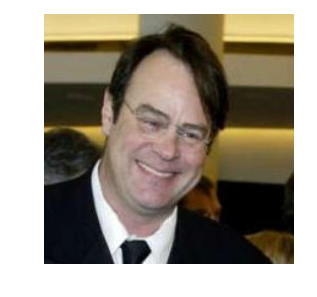

------------------------------
Oh, a human! This person looks like a Greyhound. :)


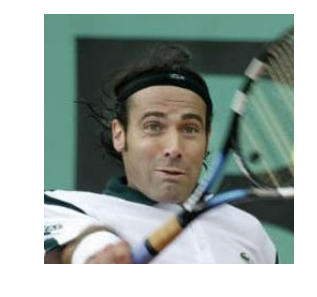

------------------------------
Oh, a human! This person looks like an Irish water spaniel. :)


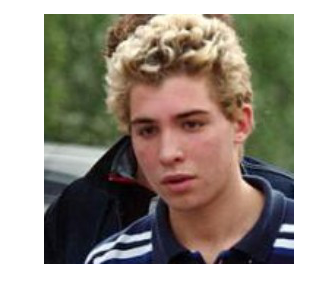

------------------------------
What a lovely dog! I think this might be a Mastiff. :)


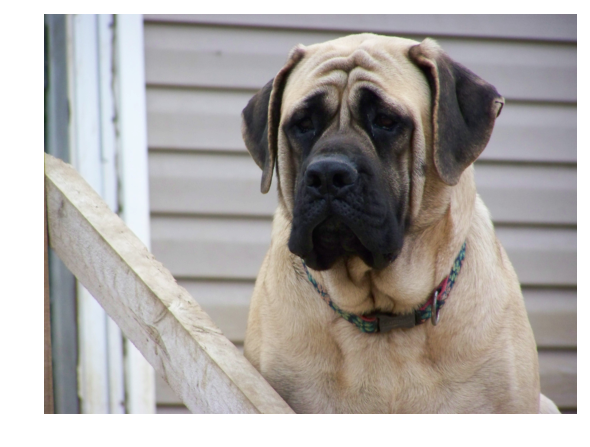

------------------------------
What a lovely dog! I think this might be a Boxer. :)


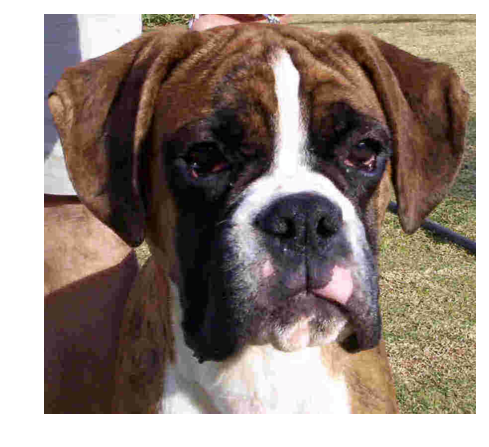

------------------------------
What a lovely dog! I think this might be a Chihuahua. :)


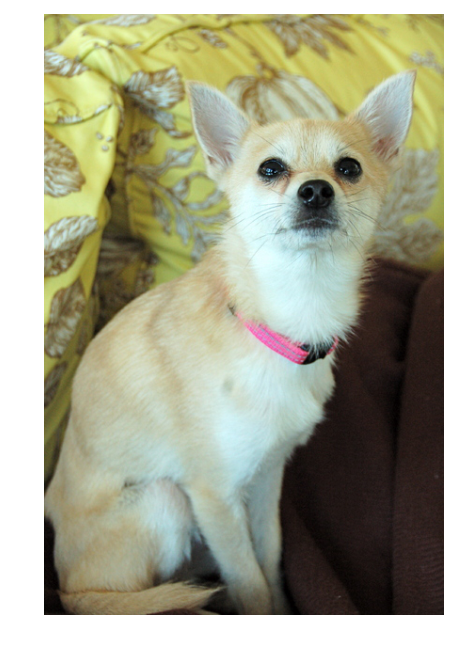

------------------------------
Hmmmm, I don't think there's a human or dog in this picture... Try another one!


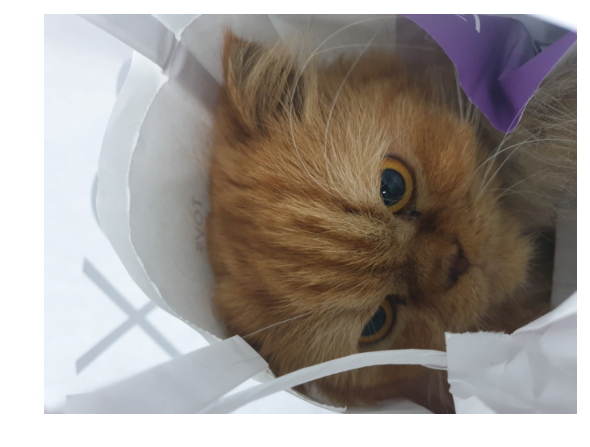

------------------------------
What a lovely dog! I think this might be a Bullmastiff. :)


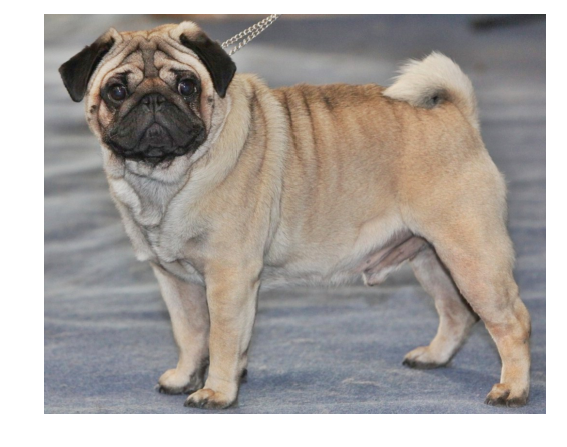

------------------------------
What a lovely dog! I think this might be a Yorkshire terrier. :)


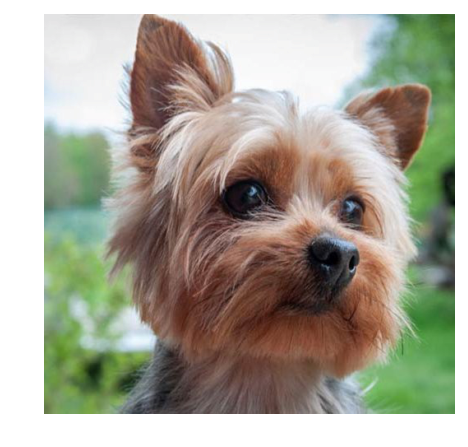

------------------------------
Oh, a human! This person looks like a Chesapeake bay retriever. :)


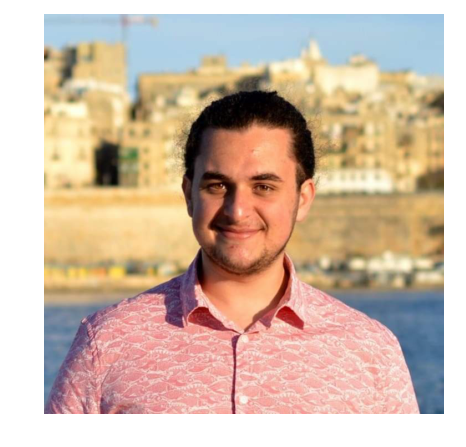

------------------------------
Oh, a human! This person looks like a Chinese shar-pei. :)


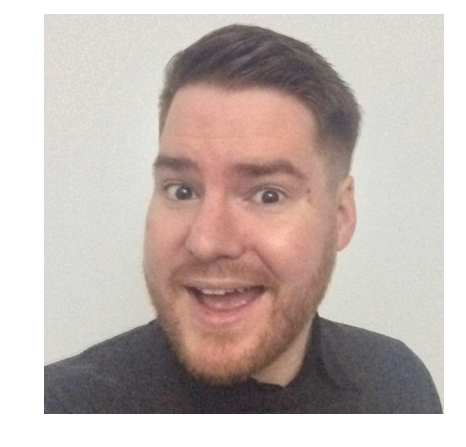

------------------------------
Hmmmm, I don't think there's a human or dog in this picture... Try another one!


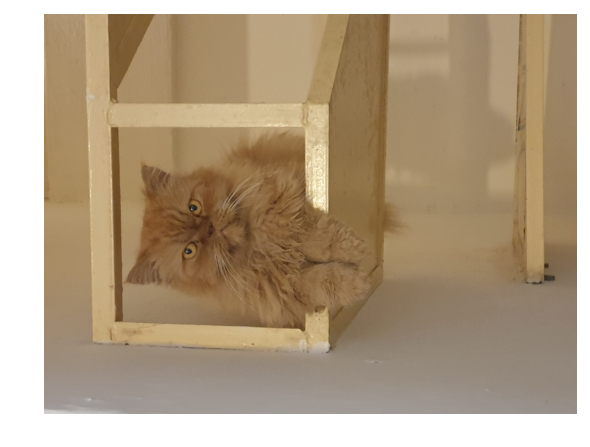

------------------------------


In [34]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[3], dog_files[1010], dog_files[777])):
    run_app(file)

test_files = np.array(glob("test_images/*"))
for file in test_files:
    run_app(file)